#MOVIE RECOMMENDATION SYSTEM


###Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

###Loading the dataset

In [3]:
links=pd.read_csv('links.csv')
movies=pd.read_csv('movies.csv')
ratings=pd.read_csv('ratings.csv')
tags=pd.read_csv('tags.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
movies.shape,tags.shape,ratings.shape,links.shape

((9742, 3), (3683, 4), (100836, 4), (9742, 3))

###Creating a dataset with movie titles and its corresponding ratings

In [9]:
mov_t=pd.DataFrame(movies[['movieId','title']])
mov_t

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [10]:
movie_title_rating=pd.merge(ratings,mov_t,how='inner',on='movieId')
movie_title_rating.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [11]:
rf_dataset=movie_title_rating.groupby(by=['userId','title'],as_index=False).agg({"rating":"mean"})

In [12]:
rf_dataset

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0
...,...,...,...
100827,610,[REC] (2007),4.0
100828,610,[REC]² (2009),3.5
100829,610,[REC]³ 3 Génesis (2012),3.0
100830,610,xXx (2002),2.0


####The rf_dataset contains the userId,title and rating groupbyed the userId

###Plotting the count for each rating

Text(0.5, 1.0, 'Distribution of ratings')

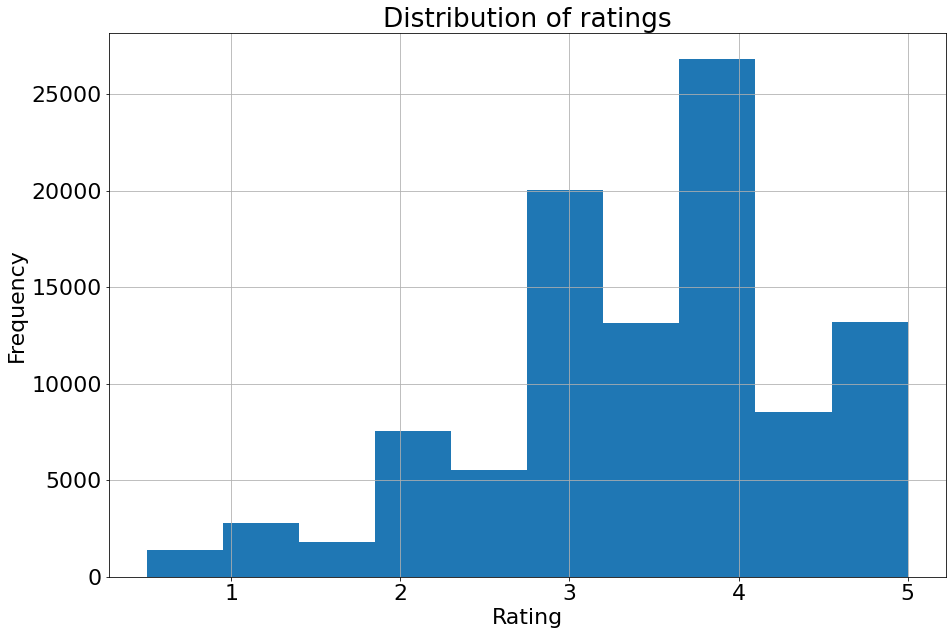

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
ratings['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

####The above plot tells us that most of the users who watched movies gave it a rating of 4 followed by 3.

###Visualizing the count of each movies

In [14]:
movies_count=pd.DataFrame(ratings.groupby('movieId').size(),columns=['movie_count'])

In [15]:
movies_count

,movie_count
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


Text(0, 0.5, 'number of ratings')

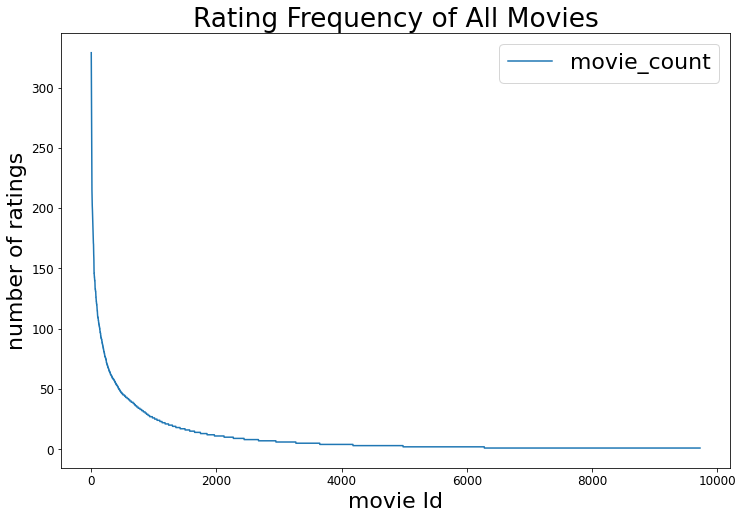

In [16]:
ax = movies_count \
    .sort_values('movie_count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

####We can see the issue of long tail property in this dataset. i.e movie after Id 2000 to 9724 have very less number of user ratings.We will deal with issue later

##Employing K Nearest Neighbour on our Model

###Creating a df_moive dataset which has the movieId as the column number and the userId as the row number

In [17]:
df_movie=ratings.pivot(index='userId',columns='movieId',values='rating')
df_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_movie.fillna(0,inplace=True)
df_movie

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Creating a sparse matrix from the df_movie dataset so that we can operate on it further smoothly

In [19]:
user_movie_sparse=csr_matrix(df_movie.values)
user_movie_sparse

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

###Fitting the K Nearest Neighbours model to the sparse matrix

In [20]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

###Further we define a function to get the top k (k is passed of as an argument to the function) users matching a given user.

In [21]:
def similar_users(userId,n_users=10):
  knn_input=np.asarray([df_movie.values[userId-1]])
  dists,idxs=knn_model.kneighbors(knn_input,n_neighbors=n_users+1)
  
  print(f'Top {n_users} users who are the most similar to user {userId} are: ')
  for i in range(1,len(dists[0])):
    print(f'{i} User {idxs[0][i]+1} separated by distance of {dists[0][i]}')
  return idxs.flatten()[1:]+1,dists.flatten()[1:]

####Testing this similar_user() function

In [22]:
from pprint import pprint

In [23]:
user_id = 77
print( f'Some Movies seen by the User {user_id}:')
pprint(list(rf_dataset[rf_dataset['userId'] == user_id]['title'])[:10])
similar_user_list, distance_list = similar_users(user_id,10)

Some Movies seen by the User 77:
["Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'Batman Begins (2005)',
 'Bourne Identity, The (2002)',
 'Bourne Ultimatum, The (2007)',
 'Catch Me If You Can (2002)',
 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)',
 'Dark Knight, The (2008)',
 'Donnie Darko (2001)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'Gladiator (2000)']
Top 10 users who are the most similar to user 77 are: 
1 User 399 separated by distance of 0.5303046091304774
2 User 30 separated by distance of 0.5512437341520852
3 User 407 separated by distance of 0.5706275328702807
4 User 189 separated by distance of 0.5986455270692603
5 User 25 separated by distance of 0.6184055063873423
6 User 86 separated by distance of 0.623934557446298
7 User 112 separated by distance of 0.6379959064605797
8 User 366 separated by distance of 0.6410001284979502
9 User 487 separated by distance of 0.6457905229877801
10 User 475 separated by distance of 0.6493705457630571


###Now from here there are two ways to proceed further in our recommendation journey
###i)Take the average of the existing rating given by the similar users and pick the top 10 or required number of movies to recommend to the input user.

###ii)Define weights to ratings by each similar user based on their distance from the input user.

###The second method seems like a better option from the first as it reduces the chances of recommending movies liked by the users who are relatively far away from the user(based on the knn distance)

In [24]:
#assiging weights to each of the similar user
weightage_list=distance_list/np.sum(distance_list)
weightage_list

array([0.08740346, 0.09085459, 0.09404938, 0.09866723, 0.10192402,
       0.10283531, 0.10515286, 0.10564801, 0.10643755, 0.1070276 ])

In [25]:
#Getting the ratings of the movies rated by these similar users
sim_users_ratings=df_movie.values[similar_user_list]
sim_users_ratings

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [5. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [4. , 4. , 0. , ..., 0. , 0. , 0. ]])

In [26]:
#viewing the names of the movies in the df_movies_columns
movie_ids=df_movie.columns
movie_ids

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)

In [27]:
movie_list=[]
for i in range(len(movie_ids)):
  movie_list.append(mov_t.loc[mov_t['movieId']==movie_ids[i]]['title'])

In [28]:
movie_list=np.array(movie_list)

In [29]:
movie_list=movie_list.flatten()

In [30]:
movie_list

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

####Concating the weigtage matrix with zeroes so that it gets easier to get the movies from the df_movies matrix by taking the cross product

In [31]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movie_list))
weightage_list.shape

(10, 9724)

In [32]:
new_rating_matrix = weightage_list*sim_users_ratings
mean_rating = new_rating_matrix.sum(axis =0)
mean_rating

array([1.88959237, 0.4281104 , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [33]:
def recommend_movies(n):
  n = min(len(mean_rating),n)
  print(list(movie_list[np.argsort(mean_rating)[::-1][:n]]))

In [34]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)', 'Forrest Gump (1994)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Casablanca (1942)', 'Toy Story (1995)', 'Godfather, The (1972)', 'Star Wars: Episode IV - A New Hope (1977)', 'Good Will Hunting (1997)', 'Monty Python and the Holy Grail (1975)']


###This recommender system has some drawbacks 
###i)It can at times recommend movies which are already seen by the input user

###ii)It can also recommend movies not seen by any of the similar users

###We tried to built a new model based on these limitations

In [35]:
def filtered_movie_recommendations(n):
  
  first_zero_index = np.where(mean_rating == 0)[0][-1]
  sortd_index = np.argsort(mean_rating)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(rf_dataset[rf_dataset['userId'] == user_id]['title'])
  filtered_movie_list = list(movie_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    for i in final_movie_list:
      print(i)
    #print(final_movie_list)

In [36]:
filtered_movie_recommendations(10)

Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Forrest Gump (1994)
Casablanca (1942)
Toy Story (1995)
Godfather, The (1972)
Good Will Hunting (1997)
Monty Python and the Holy Grail (1975)
Apollo 13 (1995)
Die Hard: With a Vengeance (1995)


In [40]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def similar_users(userId,n_users=10):
    knn_input=np.asarray([df_movie.values[userId-1]])
    dists,idxs=knn_model.kneighbors(knn_input,n_neighbors=n_users+1)
    
    print(f'Top {n_users} users who are the most similar to user {userId} are: ')
    for i in range(1,len(dists[0])):
      print(f'{i} User {idxs[0][i]+1} separated by distance of {dists[0][i]}')
    return idxs.flatten()[1:]+1,dists.flatten()[1:]


  def filtered_movie_recommendations(n):
  
    first_zero_index = np.where(mean_rating == 0)[0][-1]
    sortd_index = np.argsort(mean_rating)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(rf_dataset[rf_dataset['userId'] == user_id]['title'])
    filtered_movie_list = list(movie_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      for i in final_movie_list:
        print(i)

  similar_user_list, distance_list = similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  sim_users_ratings = df_movie.values[similar_user_list]
  movies_list = df_movie.columns
  movie_list=[]
  for i in range(len(movie_ids)):
    movie_list.append(mov_t.loc[mov_t['movieId']==movie_ids[i]]['title'])
  movie_list=np.array(movie_list)
  movie_list=movie_list.flatten()
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*sim_users_ratings
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [41]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
number of similar users to be considered
Enter number of movies to be recommended:
Top 5 users who are the most similar to user 69 are: 
1 User 335 separated by distance of 0.6391691177102234
2 User 400 separated by distance of 0.6822339717811792
3 User 197 separated by distance of 0.7092894465125141
4 User 72 separated by distance of 0.7147011993795044
5 User 399 separated by distance of 0.7307369052552346

Movies recommended based on similar users are: 

Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Casablanca (1942)


## Storing the Model to be used by the App Program

In [42]:
import pickle

In [55]:
data={"model":knn_model,"movie_list":movie_list,"weightage_list":weightage_list,
      "mean_rating":mean_rating,"df_movie":df_movie,"movie_ids":movie_ids,'mov_t':mov_t,
      "rf_dataset":rf_dataset}
      
with open('saved_model.pkl', 'wb') as file:
    pickle.dump(data,file)

## Testing Stored Model

In [44]:
with open('saved_model.pkl', 'rb') as file:
    data=pickle.load(file)

In [46]:
model=data['model']
movie_list=data['movie_list']
weightage_list=data['weightage_list']
mean_rating=data['mean_rating']

In [47]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
number of similar users to be considered
Enter number of movies to be recommended:
Top 3 users who are the most similar to user 5 are: 
1 User 470 separated by distance of 0.47932920424735703
2 User 229 separated by distance of 0.48266710413766245
3 User 565 separated by distance of 0.4886746437839189

Movies recommended based on similar users are: 

Silence of the Lambs, The (1991)
Forrest Gump (1994)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
